# Filtrado de datos
Se eliminan duplicados, filas sin sinópisis y/o sin géneros. Luego se seleccionan los 18 géneros más comunes.

In [ ]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Loading dataset
dataset = load_dataset("pkchwy/letterboxd-all-movie-data")

train = dataset['train']

df = pd.json_normalize(train)



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

full_dump.jsonl:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/847209 [00:00<?, ? examples/s]

In [ ]:
# filter all
filtered_df =  df.drop_duplicates(subset=['title'])

zero_genres = filtered_df['genres'].apply(lambda x: len(x) if isinstance(x, (list, tuple)) else 0).eq(0)
filtered_df = filtered_df[~zero_genres]

zero = filtered_df['synopsis'].apply(lambda x: len(x) if isinstance(x, str) else 0).eq(0)
filtered_df = filtered_df[~zero]

top18 = [
    "Drama", "Documentary", "Comedy", "Animation",
    "Horror", "Romance", "Thriller", "Music",
    "Action", "Crime", "Family", "Adventure",
    "Fantasy", "Science Fiction", "Mistery", "History",
    "War", "Western"
]

mask = filtered_df["genres"].apply(lambda g: all(genre in top18 for genre in g))
filtered_df = filtered_df[mask].copy()
filtered_df = filtered_df[["title","synopsis", "genres"]]

# Creación de datasets finales (con variedad de clases)
Se separa el dataset original según su uso:

Dataset One-genre: solo películas asignadas a un único género.
Dataset Multi-genre: películas con más de un género asignado.

Para cada uno se hará a su vez un split 80-10-10





## One Genre

In [ ]:
one_genre_df = filtered_df[filtered_df["genres"].apply(lambda x: len(x) == 1)]
unique_genres = one_genre_df["genres"].apply(lambda x: x[0]).unique()

for genre in unique_genres:
  count = len(one_genre_df[one_genre_df["genres"].apply(lambda x: x[0] == genre)])
  if count < 1500:
    one_genre_df = one_genre_df[one_genre_df["genres"].apply(lambda x: x[0] != genre)]

unique_genres = one_genre_df["genres"].apply(lambda x: x[0]).unique()

selected_films = {}
for genre in unique_genres:
  selected_films[genre] = one_genre_df[one_genre_df["genres"].apply(lambda x: x[0] == genre)].sort_values(by="synopsis", ascending=False)[:1500]
  selected_films[genre]["genre"] = genre
  selected_films[genre].drop(columns=["genres"], inplace=True)

one_genre_df = pd.concat(selected_films.values())

## Multigenre

In [ ]:
one_genre_df = filtered_df[filtered_df["genres"].apply(lambda x: len(x) == 1)]
unique_genres = one_genre_df["genres"].apply(lambda x: x[0]).unique()

# nos quedamos con mil muestras de cada genero para poder tener algo de variedad a la hora de aprender -> 1 genero: 18000 ejemplares
# al resto le damos la misma cantidad de ejemplares:
selected_films = {}
for genre in unique_genres:
  selected_films[genre] = one_genre_df[one_genre_df["genres"].apply(lambda x: x[0] == genre)].sort_values(by="synopsis", ascending=False)[:100]

multi_genre_df = pd.concat(selected_films.values())
print(f"1 genre real: {len(multi_genre_df)}/18000")

two_genre_df = filtered_df[filtered_df["genres"].apply(lambda x: len(x) == 2)]
multi_genre_df = pd.concat([multi_genre_df, two_genre_df.sort_values(by="synopsis", ascending=False)[:1700]], axis=0)

three_genre_df = filtered_df[filtered_df["genres"].apply(lambda x: len(x) == 3)]
multi_genre_df = pd.concat([multi_genre_df, three_genre_df.sort_values(by="synopsis", ascending=False)[:1700]], axis=0)

#four_genre_df = filtered_df[filtered_df["genres"].apply(lambda x: len(x) == 4)]
#multi_genre_df = pd.concat([multi_genre_df, four_genre_df.sort_values(by="synopsis", ascending=False)[:1700]], axis=0)

# multigenre df has the following distribution:
# 1 genre: 1800
# 2 genres: 1800
# 3 genres: 1800
#not used: 4 genres: 1800
print(len(multi_genre_df))

1 genre real: 1700/18000
5100


# Análisis contenido de las sinopsis (por si se puede reutilizar para: ¿Existe una correlación entre la longitud de la sinopsis y el género?)

In [ ]:
import numpy as np
import html
import nltk

from nltk.corpus import stopwords
import string

nltk.download("stopwords")
all_synopsis = filtered_df["synopsis"]
len_synopsis = filtered_df["synopsis"].fillna("").apply(len).tolist()
total_empty_sinopsis = len_synopsis.count(0)
print(f"Total empty Synopsis: {total_empty_sinopsis}")

mean_len_before_filtering = np.mean(len_synopsis)
print(f"Synopsis mean len with empty: {mean_len_before_filtering}")
filtered_df = filtered_df[filtered_df["synopsis"].fillna("").apply(len) > 0]
print(f"Filtered_df len: {len(filtered_df)}")

len_synopsis = filtered_df["synopsis"].apply(len).tolist()
mean_len_before_filtering = np.mean(len_synopsis)
print(f"Synopsis mean len without empty: {mean_len_before_filtering}")

stop_words = stopwords.words("english")

def preprocess_text(text: str) -> str:
    """Limpia antes de tokenizar."""
    text = text.lower()
    text = text.replace("\\\\n", " ")
    text = html.unescape(text)
    exclude = {'#', "'", "@"}
    text = ''.join(char for char in text if char not in string.punctuation or char in exclude)
    return text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Total empty Synopsis: 0
Synopsis mean len with empty: 278.60426850095996
Filtered_df len: 424505
Synopsis mean len without empty: 278.60426850095996


In [ ]:
def extract_adj_adv(text):
    doc = nlp(text)
    return [token.lemma_.lower() for token in doc if token.pos_ in ("ADJ")]

# Prediccion de generos

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import numpy as np

train_df, test_df = train_test_split(multi_genre_df, test_size=0.2, random_state=42)

mlb = MultiLabelBinarizer()
mlb.fit(multi_genre_df["genres"])

train_df["labels"] = mlb.transform(train_df["genres"]).astype(np.float32).tolist()
test_df["labels"] = mlb.transform(test_df["genres"]).astype(np.float32).tolist()

dataset_dict = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "test": Dataset.from_pandas(test_df)
})

In [ ]:
from transformers import AutoTokenizer
import torch

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_function(examples):
  combined_texts = [f"{t} - {s}" for t, s in zip(examples["title"], examples["synopsis"])]
  texts = combined_texts
  return tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=256
    )

encoded_dataset_raw = dataset_dict.map(tokenize_function, batched=True)
encoded_dataset = encoded_dataset_raw.remove_columns(["genres", "synopsis"])

Map:   0%|          | 0/4080 [00:00<?, ? examples/s]

Map:   0%|          | 0/1020 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification,Trainer, TrainingArguments

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(mlb.classes_),
    problem_type="multi_label_classification"
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import numpy as np
from sklearn.metrics import f1_score
from google.colab import drive
drive.mount('/content/drive')


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))  # sigmoid
    preds = (probs > 0.5).astype(int)
    macro_f1 = f1_score(labels, preds, average="macro")
    return {"macro_f1": macro_f1}

training_args = TrainingArguments(
    report_to="none",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


Mounted at /content/drive


/tmp/ipython-input-2869055852.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
LAST_CHECKPOINT_PATH = "/content/drive/MyDrive/TP NLP/Entrega Final/Corridas titulo/checkpoint-3400" # Remplazar con tu ruta real

#trainer.train(resume_from_checkpoint=LAST_CHECKPOINT_PATH)
trainer.train()

Epoch,Training Loss,Validation Loss,Macro F1
1,0.308800,0.268551,0.259568
2,0.243100,0.245227,0.437146
3,0.189700,0.240637,0.523205
4,0.140200,0.243817,0.539558
5,0.098400,0.248602,0.568782


TrainOutput(global_step=2550, training_loss=0.19396449799631157, metrics={'train_runtime': 1360.6103, 'train_samples_per_second': 14.993, 'train_steps_per_second': 1.874, 'total_flos': 2684094206976000.0, 'train_loss': 0.19396449799631157, 'epoch': 5.0})

{'eval_loss': 0.24860210716724396, 'eval_macro_f1': 0.5687823296791744, 'eval_runtime': 16.0491, 'eval_samples_per_second': 63.555, 'eval_steps_per_second': 7.976, 'epoch': 5.0}
PredictionOutput(predictions=array([[ 3.3627043 , -3.1424074 , -4.379307  , ..., -2.7944262 ,
        -5.145084  , -5.1737485 ],
       [-3.251606  ,  0.47416872, -0.8236833 , ..., -5.3579073 ,
        -5.281879  , -3.9115047 ],
       [-3.0830865 , -4.115209  , -3.8814867 , ..., -4.060348  ,
        -3.7442644 , -5.0612154 ],
       ...,
       [-3.887767  , -4.569252  , -3.807886  , ..., -5.0922785 ,
         0.4925133 , -4.7013583 ],
       [ 1.2221845 , -1.6153301 , -2.7654612 , ..., -0.09279787,
        -3.6358776 , -4.3132434 ],
       [ 0.40927905, -0.6466257 , -0.83012795, ..., -3.4216008 ,
        -5.782998  , -5.339094  ]], dtype=float32), label_ids=array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0.,

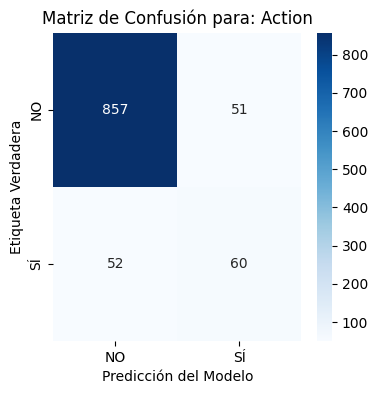


Matriz de Confusión para: Action
[[857  51]
 [ 52  60]]
---------------------------------------


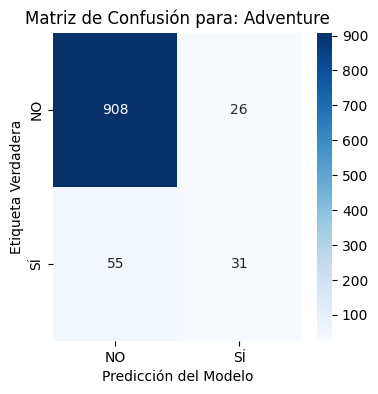


Matriz de Confusión para: Adventure
[[908  26]
 [ 55  31]]
---------------------------------------


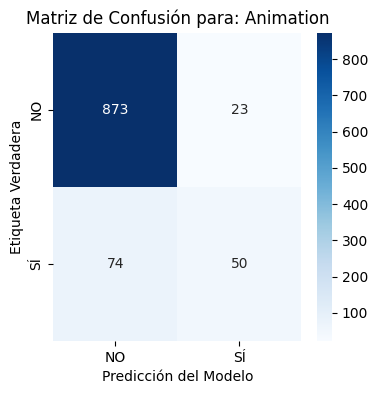


Matriz de Confusión para: Animation
[[873  23]
 [ 74  50]]
---------------------------------------


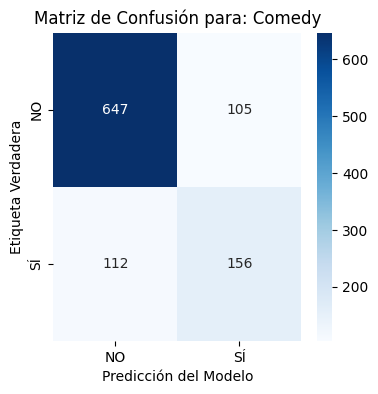


Matriz de Confusión para: Comedy
[[647 105]
 [112 156]]
---------------------------------------


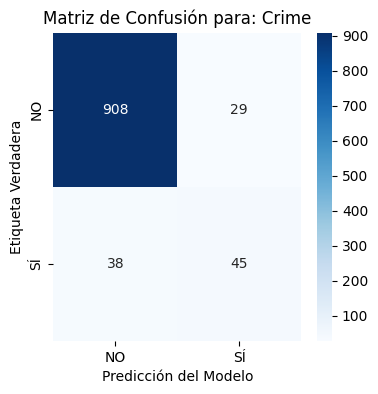


Matriz de Confusión para: Crime
[[908  29]
 [ 38  45]]
---------------------------------------


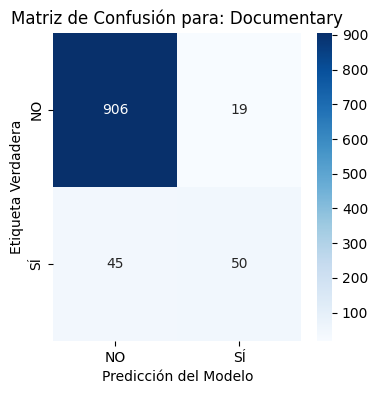


Matriz de Confusión para: Documentary
[[906  19]
 [ 45  50]]
---------------------------------------


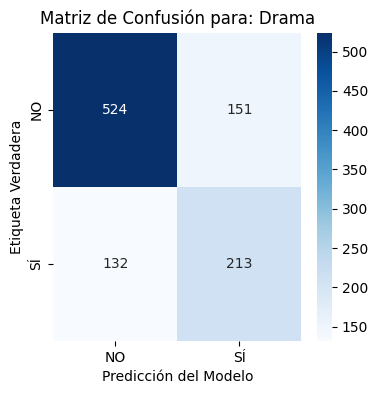


Matriz de Confusión para: Drama
[[524 151]
 [132 213]]
---------------------------------------


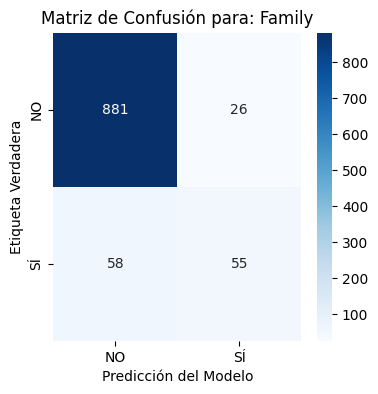


Matriz de Confusión para: Family
[[881  26]
 [ 58  55]]
---------------------------------------


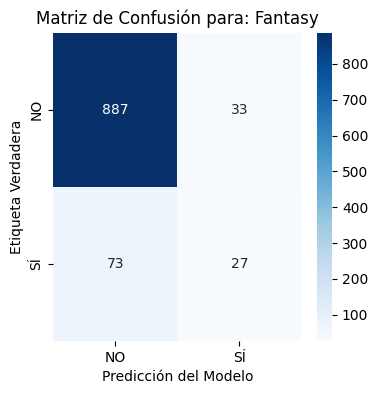


Matriz de Confusión para: Fantasy
[[887  33]
 [ 73  27]]
---------------------------------------


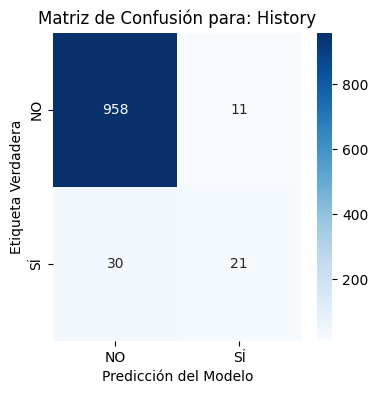


Matriz de Confusión para: History
[[958  11]
 [ 30  21]]
---------------------------------------


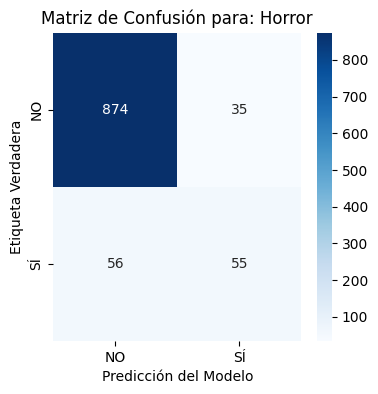


Matriz de Confusión para: Horror
[[874  35]
 [ 56  55]]
---------------------------------------


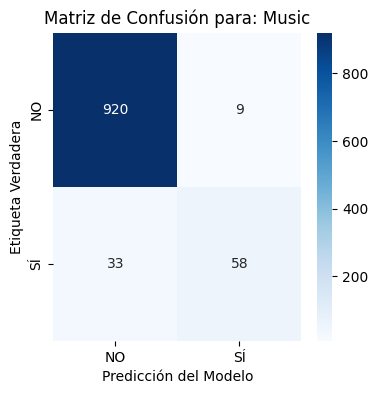


Matriz de Confusión para: Music
[[920   9]
 [ 33  58]]
---------------------------------------


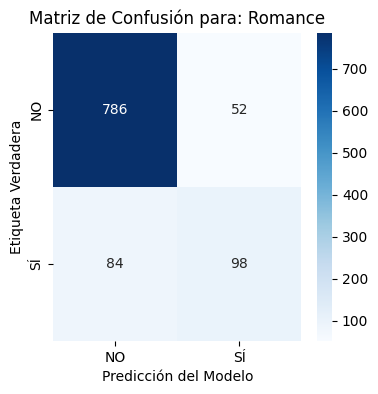


Matriz de Confusión para: Romance
[[786  52]
 [ 84  98]]
---------------------------------------


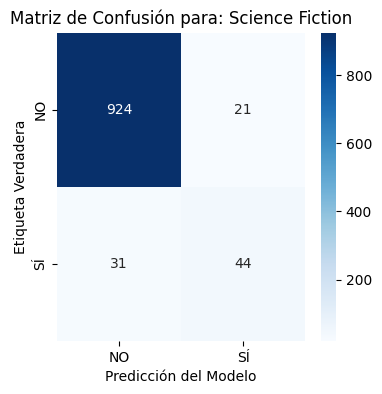


Matriz de Confusión para: Science Fiction
[[924  21]
 [ 31  44]]
---------------------------------------


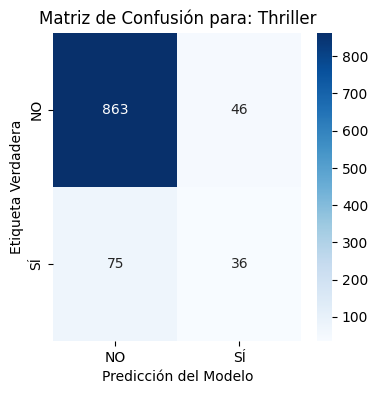


Matriz de Confusión para: Thriller
[[863  46]
 [ 75  36]]
---------------------------------------


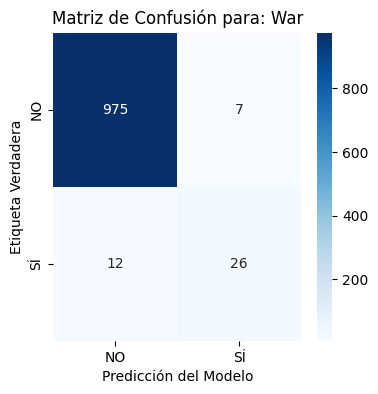


Matriz de Confusión para: War
[[975   7]
 [ 12  26]]
---------------------------------------


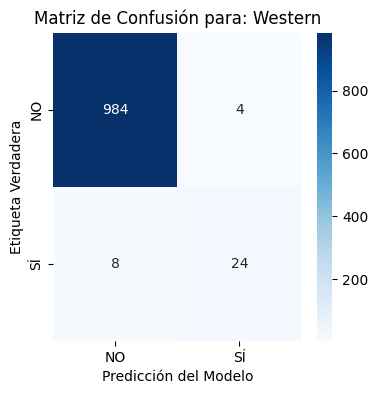


Matriz de Confusión para: Western
[[984   4]
 [  8  24]]
---------------------------------------


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

eval=trainer.evaluate()
predictions = trainer.predict(encoded_dataset["test"])
logits = predictions.predictions
true_labels = predictions.label_ids
print(eval)
print(predictions)
print(mlb.classes_)


probs = 1 / (1 + np.exp(-logits))
preds_binary = (probs > 0.5).astype(int)
print("\n" + "="*60)
print("MATRICES DE CONFUSIÓN BINARIA INDIVIDUALES")
print("="*60)

# Iterar sobre cada clase/género
for i, genre_name in enumerate(mlb.classes_):

    # Obtener las etiquetas reales (columna i) y las predicciones (columna i)
    y_true_genre = true_labels[:, i]
    y_pred_genre = preds_binary[:, i]

    # Crear la Matriz de Confusión 2x2 para este género
    cm = confusion_matrix(y_true_genre, y_pred_genre)

    # Visualizar la matriz (opcional, pero ayuda mucho)
    plt.figure(figsize=(4, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['NO', 'SÍ'],
        yticklabels=['NO', 'SÍ']
    )
    plt.title(f'Matriz de Confusión para: {genre_name}')
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Predicción del Modelo')
    plt.show()
    plt.close()

    print(f"\nMatriz de Confusión para: {genre_name}")
    print(cm)
    print("---------------------------------------")

In [ ]:
import numpy as np
import pandas as pd
# Asegúrate de que encoded_dataset["test"] sea accesible y contenga la columna 'synopsis'
# (o que se pueda mapear de nuevo a la sinopsis original del test_df)

# --- (Asumo que el código anterior ya se ejecutó: predictions, logits, true_labels, preds_binary, mlb) ---

# --- Asumo que tienes el dataset de prueba original disponible con la columna 'synopsis' ---
# Si NO lo tienes, reemplaza esta línea con el dataset que contiene las sinopsis:
test_title = encoded_dataset_raw["test"]
# Si la columna 'synopsis' fue eliminada, necesitarás mapear los índices a tu DataFrame original (test_df)
# En este ejemplo, usaré el índice del dataset.

print("\n" + "="*80)
print("EJEMPLOS DE INFERENCIA POR GÉNERO (Verdadero Positivo o Falso Negativo)")
print("="*80)

# Almacena los índices ya utilizados para no repetir la sinopsis
used_indices = set()

# Iterar sobre cada clase/género para encontrar un ejemplo
for i, genre_name in enumerate(mlb.classes_):

    # 1. Buscar índices donde la etiqueta real para este género es SÍ (1)
    # y que no hayamos usado ya (para mostrar un ejemplo único si es posible)
    is_genre_true = np.where(true_labels[:, i] == 1)[0]

    example_idx = -1

    # Buscar el primer índice donde el género es 1 Y el índice no se haya usado
    for idx in is_genre_true:
        if idx not in used_indices:
            example_idx = idx
            used_indices.add(idx)
            break

    # Si no se encuentra un ejemplo único, al menos encuentra el primero
    if example_idx == -1 and len(is_genre_true) > 0:
        example_idx = is_genre_true[0]

    example_idx = int(example_idx)
    if example_idx != -1:
        title=test_title["title"][example_idx]
        # 2. Recuperar la información de la fila
        sinopsis = test_title["synopsis"][example_idx] # O test_df.iloc[example_idx]['synopsis']

        # Etiqueta REAL para TODOS los géneros en esta fila
        real_vector = true_labels[example_idx, :]
        real_genres = list(mlb.inverse_transform(real_vector.reshape(1, -1))[0])

        # Predicción para TODOS los géneros en esta fila
        pred_vector = preds_binary[example_idx, :]
        predicted_genres = list(mlb.inverse_transform(pred_vector.reshape(1, -1))[0])

        # 3. Imprimir el resultado
        print(f"\n🎬 GÉNERO EN EXAMEN: {genre_name.upper()}")
        print(f"   - Titulo: {title}")
        print(f"   - Sinopsis (Fragmento): {sinopsis}...")
        print(f"   - Valor REAL (Todos): {real_genres}")
        print(f"   - Valor PREDECIDO (Todos): {predicted_genres}")

        # Estado del género específico:
        status = ""
        if real_vector[i] == 1 and pred_vector[i] == 1:
            status = "✅ Verdadero Positivo (TP)"
        elif real_vector[i] == 1 and pred_vector[i] == 0:
            status = "❌ Falso Negativo (FN)"

        print(f"   - Estado para {genre_name}: {status}")

    else:
        print(f"\n🎬 GÉNERO EN EXAMEN: {genre_name.upper()}")
        print("   - No se encontraron ejemplos en el conjunto de prueba con etiqueta Real=SÍ.")

print("\n" + "="*80)


EJEMPLOS DE INFERENCIA POR GÉNERO (Verdadero Positivo o Falso Negativo)

🎬 GÉNERO EN EXAMEN: ACTION
   - Titulo: Gangster Payday
   - Sinopsis (Fragmento): Wong Kam-Kwei, a gang boss on the decline, overseeing bathhouses and karaoke bars, falls for a small restaurant owner, Mei. He begins to help her business, and learns that Mei is already in love with Leung, a member of his gang. He’s also like a brother to Kam-Kwei. When a rival gang hoping to steal his territory kills Leung, the only thing left for Kam-Kwei to do now is to protect Mei and avenge Leung....
   - Valor REAL (Todos): ['Action', 'Comedy', 'Crime']
   - Valor PREDECIDO (Todos): ['Action']
   - Estado para Action: ✅ Verdadero Positivo (TP)

🎬 GÉNERO EN EXAMEN: ADVENTURE
   - Titulo: The Wizard of Oz
   - Sinopsis (Fragmento): Young Dorothy finds herself in a magical world where she makes friends with a lion, a scarecrow and a tin man as they make their way along the yellow brick road to talk with the Wizard and ask for t